In [1]:
import spateo as st
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.colors as clr

st.config.n_threads = 8
# %config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
# %config InlineBackend.figure_format = 'retina'

2023-05-30 18:25:03.898883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 18:25:05.129644: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 18:25:13.646750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wuxinchao/.local/lib/python3.9/site-packages
2023-05-30 18:25:13.647019: W tensor

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object


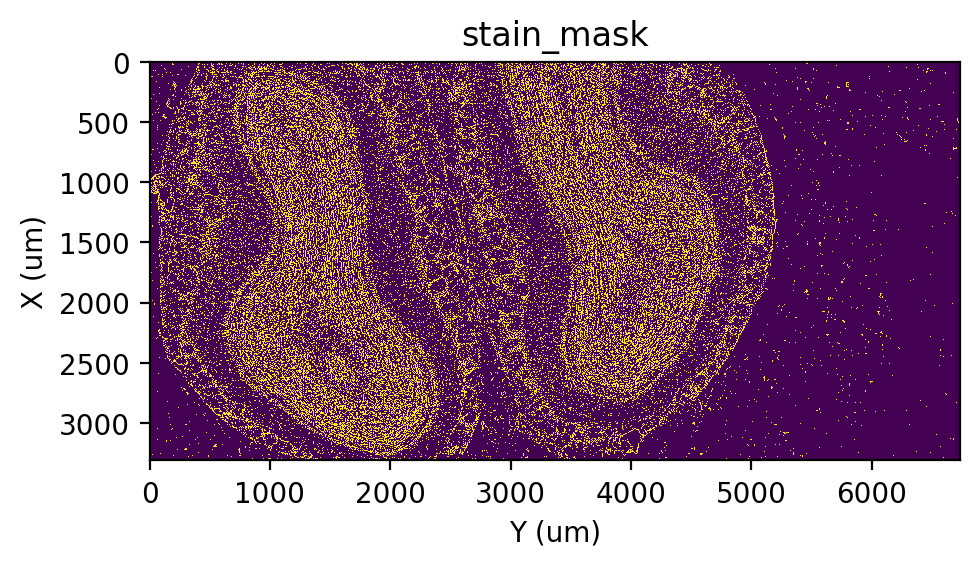

|-----> <select> stain_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 20.
|-----> Finding peaks with minimum distance 20.
|-----> <insert> stain_distances to layers in AnnData Object.
|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> Constructing cell mask from staining image.
|-----> <insert> stain_cell_mask to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_cell_mask layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object
|-----> Running Watershed.
|-----? Some labels have area greater than 10000. If you are segmenting based on RNA, consider using `st.cs.label_connected_components` 

In [4]:
adata = st.io.read_bgi_agg("D2_bgi_new.tsv", "CN13_D2_HE.tiff",prealigned=False)

# watershed-based approach
st.cs.mask_nuclei_from_stain(adata)
st.pl.imshow(adata, 'stain_mask')

# st.cs.find_peaks_from_mask(adata, 'stain', 7)
st.cs.find_peaks_from_mask(adata, 'stain', 20)
st.cs.watershed(adata, 'stain', 5, out_layer='watershed_labels')

# Expand labels to cytoplasm
st.cs.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.cs.watershed(
    adata, 'stain',
    mask_layer='stain_cell_mask',
    markers_layer='watershed_labels',
    out_layer='cell_d20_labels',
)

# load ilastik mask
il_mask = plt.imread("il_mask.jpg")
il_mask = cv2.resize(il_mask.astype(np.uint8),
                     adata.layers["stain"].T.shape)
adata.layers["il_mask"] = il_mask
adata.layers["il"] = adata.layers["il_mask"]

# Draw boundaries
# adata[400:400+520,1100:1100+667] is ROI
st.cs.utils.get_cell_shape(adata, layer="cell_d20_labels", thickness=1)

|-----> <select> stain layer in AnnData Object
|-----> <select> cell_d20_labels_boundary layer in AnnData Object


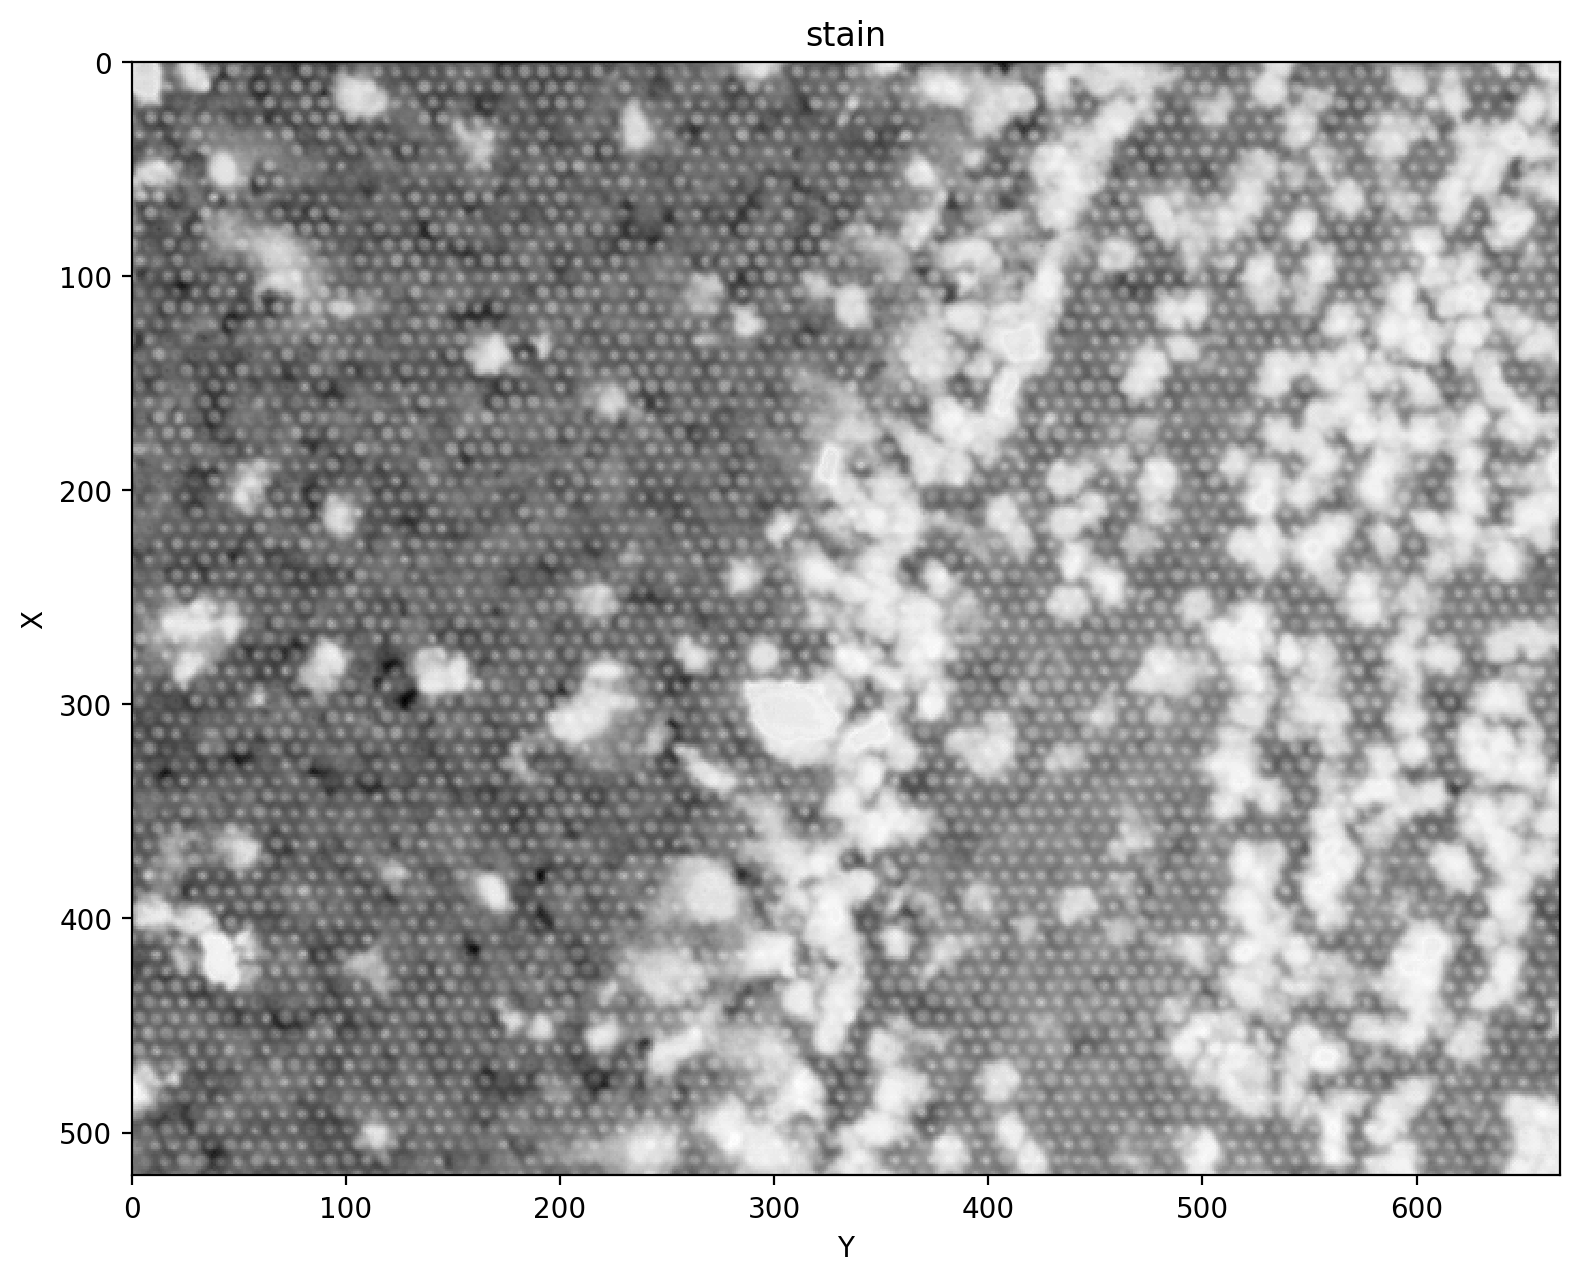

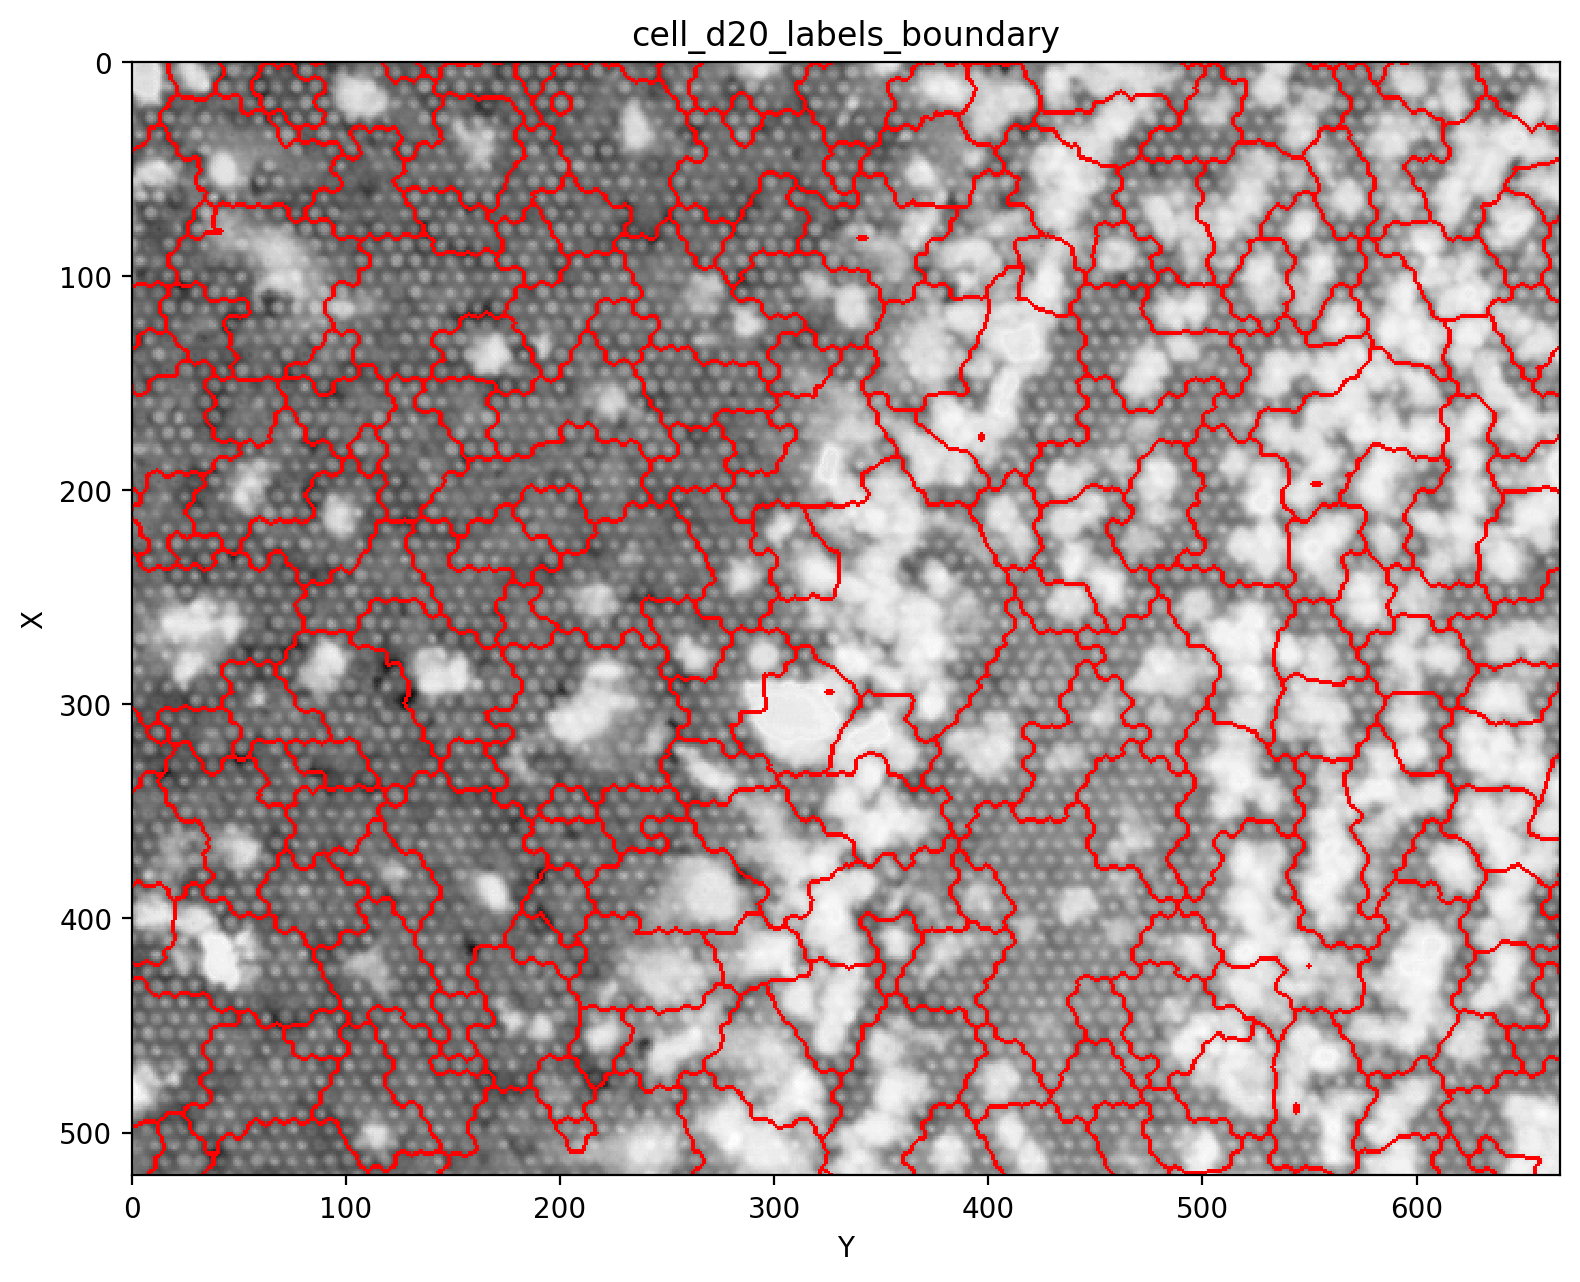

In [6]:
fig, axes = plt.subplots(figsize=(8, 8), tight_layout=True)
st.pl.imshow(adata[400:400+520,1100:1100+667], 'stain', ax=axes, use_scale=False, save_show_or_return='return', cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#000000FF','#FFFFFFFF'], N=256))
st.pl.imshow(adata[400:400+520,1100:1100+667], 'cell_d20_labels_boundary', ax=axes, alpha=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=False, save_show_or_return='return')
plt.show()

In [7]:
dilate_rna = adata.layers["unspliced"].toarray()
dilate_kernel = np.ones((4, 4), np.uint8)
cluster_image_close = cv2.dilate(dilate_rna, dilate_kernel, iterations=1)

st.cs.utils.get_cell_shape(adata, layer="il_mask", thickness=1)
fig, axes = plt.subplots(figsize=(8,8), tight_layout=True)
# st.pl.imshow(adata[670:670+60,1380:1380+100], "unspliced", ax=axes, use_scale=False, save_show_or_return="return", alpha=1, vmax=1, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#00FF00FF'], N=256))
st.pl.imshow(adata[670:670+60,1380:1380+100], "stain", ax=axes, use_scale=False, save_show_or_return="return", alpha=0.5, cmap="gray")
st.pl.imshow(adata[670:670+60,1380:1380+100], 'il_mask', ax=axes, alpha=0.8, cmap=clr.LinearSegmentedColormap.from_list(
    'custom blue', ['#FFFFFF00','#FF0000FF'], N=256), use_scale=False, save_show_or_return="return")
axes.imshow(cluster_image_close, cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF00','#00FF00FF'], N=256), vmax=1)
# get rid of the labels and title
axes.set_xticks([])
axes.set_yticks([])
axes.set_title("")
axes.set_xlabel("")
axes.set_ylabel("")
# plt.show()
fig.savefig("D2_bgi_crop_il_rna_signal_stain.png", dpi=300)

# obstain cellxgene adata
cell_adata = st.io.read_bgi(
    # 'SS200000135TL_D1_all_bin1.txt.gz',
    "D2_bgi_new.tsv",
    segmentation_adata=adata,
    labels_layer='watershed_labels',
    add_props=True,
)
# cell_adata.write("D2_bgi_new.h5ad")

df = pd.DataFrame(cell_adata.X.sum(axis=1), columns=["n_counts"], index=cell_adata.obs.index)
cell_adata.obs["n_counts"] = df

|-----> <select> il_mask layer in AnnData Object
|-----> Set cell boundaries as value of 255
|-----> Set cell boundaries as value of 255
|-----> <insert> il_mask_boundary to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> il_mask layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


In [8]:
bin_adata = st.io.read_bgi(
    "D2_bgi_new.tsv",
    binsize=15,
    add_props=True,
)
bin_df = pd.DataFrame(bin_adata.X.sum(axis=1), columns=["n_counts"], index=bin_adata.obs.index)
bin_adata.obs["n_counts"] = bin_df
bin_adata.obs["cell_or_bin"] = "Global"
# cell_adata.obs["cell_or_bin"] = "Cell"

|-----> Using binsize=15
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.
